# Setting Environment and Importing Libraries

In [ ]:
!pip install riroriro

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!gcloud config set project g2-tfrecords
!gsutil ls

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.1, rc={
    'figure.figsize': (15, 10),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})
import riroriro.inspiralfuns as ins
import riroriro.mergerfirstfuns as me1
import riroriro.matchingfuns as mat
import riroriro.mergersecondfuns as me2
import librosa
import librosa.display
import math
import matplotlib.pyplot as plt
from scipy.signal import resample

# Generating Gravitational Wave Signals

ADAPTED FROM - https://github.com/wvanzeist/riroriro_tutorials/blob/main/example_GW.ipynb

https://joss.theoj.org/papers/10.21105/joss.02968

In [ ]:
def generate_gravitational_wave(logMc=1.4, q=0.8, D=100.0, flow=10.0, merger_type='BH'):
    M, eta = ins.get_M_and_eta(logMc=logMc,q=q)
    start_x = ins.startx(M,flow)
    end_x = ins.endx(eta,merger_type)
    x, xtimes, dt = ins.PN_parameter_integration(start_x,end_x,M,eta)
    realtimes = ins.inspiral_time_conversion(xtimes,M)
    i_phase, omega, freq = ins.inspiral_phase_freq_integration(x,dt,M)
    r, rdot = ins.radius_calculation(x,M,eta)
    A1, A2 = ins.a1_a2_calculation(r,rdot,omega,D,M,eta)
    i_Aorth, i_Adiag = ins.inspiral_strain_polarisations(A1,A2,i_phase)
    i_amp = ins.inspiral_strain_amplitude(i_Aorth,i_Adiag)
    i_time = realtimes
    i_omega = omega
    sfin, wqnm = me1.quasi_normal_modes(eta)
    alpha, b, C, kappa = me1.gIRS_coefficients(eta,sfin)
    fhat, m_omega = me1.merger_freq_calculation(wqnm,b,C,kappa)
    fhatdot = me1.fhat_differentiation(fhat)
    m_time = me1.merger_time_conversion(M)
    min_switch_ind = mat.min_switch_ind_finder(i_time,i_omega,m_time,m_omega)
    final_i_index = mat.final_i_index_finder(min_switch_ind,i_omega,m_omega)
    time_offset = mat.time_offset_finder(min_switch_ind,final_i_index,i_time,m_time)
    i_m_time, i_m_omega = mat.time_frequency_stitching(min_switch_ind,final_i_index,time_offset,i_time,i_omega,m_time,m_omega)
    i_m_freq = mat.frequency_SI_units(i_m_omega,M)
    m_phase = me2.merger_phase_calculation(min_switch_ind,final_i_index,i_phase,m_omega)
    i_m_phase = me2.phase_stitching(final_i_index,i_phase,m_phase)
    m_amp = me2.merger_strain_amplitude(min_switch_ind,final_i_index,alpha,i_amp,m_omega,fhat,fhatdot)
    i_m_amp = me2.amplitude_stitching(final_i_index,i_amp,m_amp)
    m_Aorth, m_Adiag = me2.merger_polarisations(final_i_index,m_amp,m_phase,i_Aorth)
    i_m_Aorth, i_m_Adiag = me2.polarisation_stitching(final_i_index,i_Aorth,i_Adiag,m_Aorth,m_Adiag)
    return np.array(i_m_time), np.array(i_m_Aorth), np.array(i_m_Adiag), np.array(i_m_freq)

In [ ]:
SAMPLE_RATE = 2048 

def resample_diff(dt, amp, seg=2.0):
    end = dt[-1]
    start = end - seg
    d = np.zeros(int(SR*seg))
    for i in range((int(SR*seg))):
        t = start + i/SR
        d[i] = amp[np.where(dt == dt[np.abs(dt-t).argmin()])[0][0]]
    return d

In [ ]:
m_time, m_Aorth, m_Adiag, m_freq = generate_gravitational_wave(logMc=1.4, q=0.2)

In [ ]:
d1 = resample(m_Aorth, 2)
d2 = resample_diff(m_time, m_Aorth, 2)

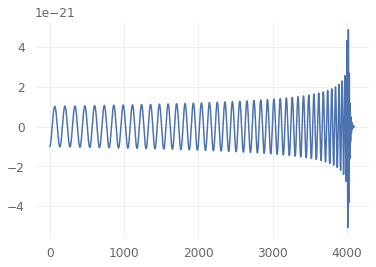

In [ ]:
plt.plot(d2)

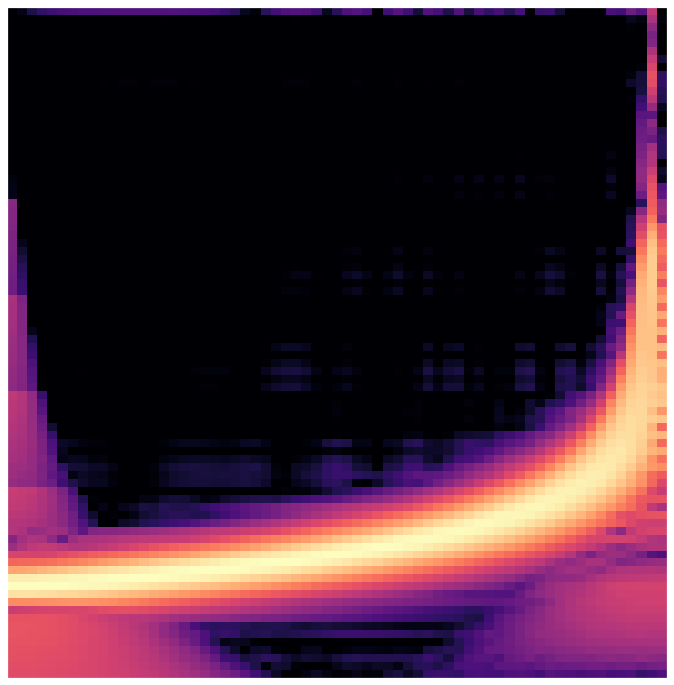

In [ ]:
hop_length = 64
C = np.abs(librosa.cqt(d2/np.max(d2), sr=SR, hop_length=hop_length, fmin=8, filter_scale=0.8, bins_per_octave=12))
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),sr=SR*2, hop_length=hop_length, bins_per_octave=12)

# Adding Noise from Dataset

https://librosa.org/doc/main/generated/librosa.display.specshow.html

This datapoint is purely noise, no gravitationl wave signal is found here.

In [ ]:
noise = np.load('/content/drive/MyDrive/0000a38978.npy')
noise = noise.transpose()

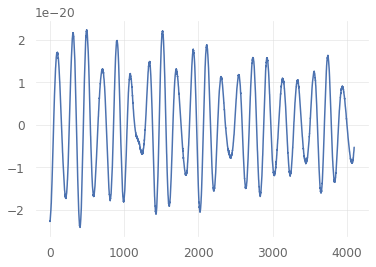

In [ ]:
plt.plot(noise[:,0])

By how much should we gain the noise when including it in the signal?

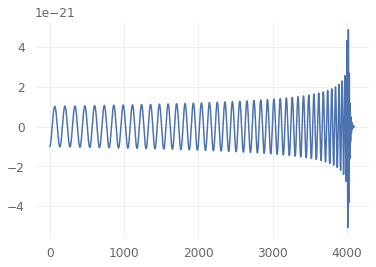

In [ ]:
plt.plot(d2)

In [ ]:
gain_intervals = [0., 1., 1/2, 1/4, 1/8, 1/16 , 1/32]

In [ ]:
def include_noise(gain, signal):
  return noise[:,0] + (gain*signal)

In [ ]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

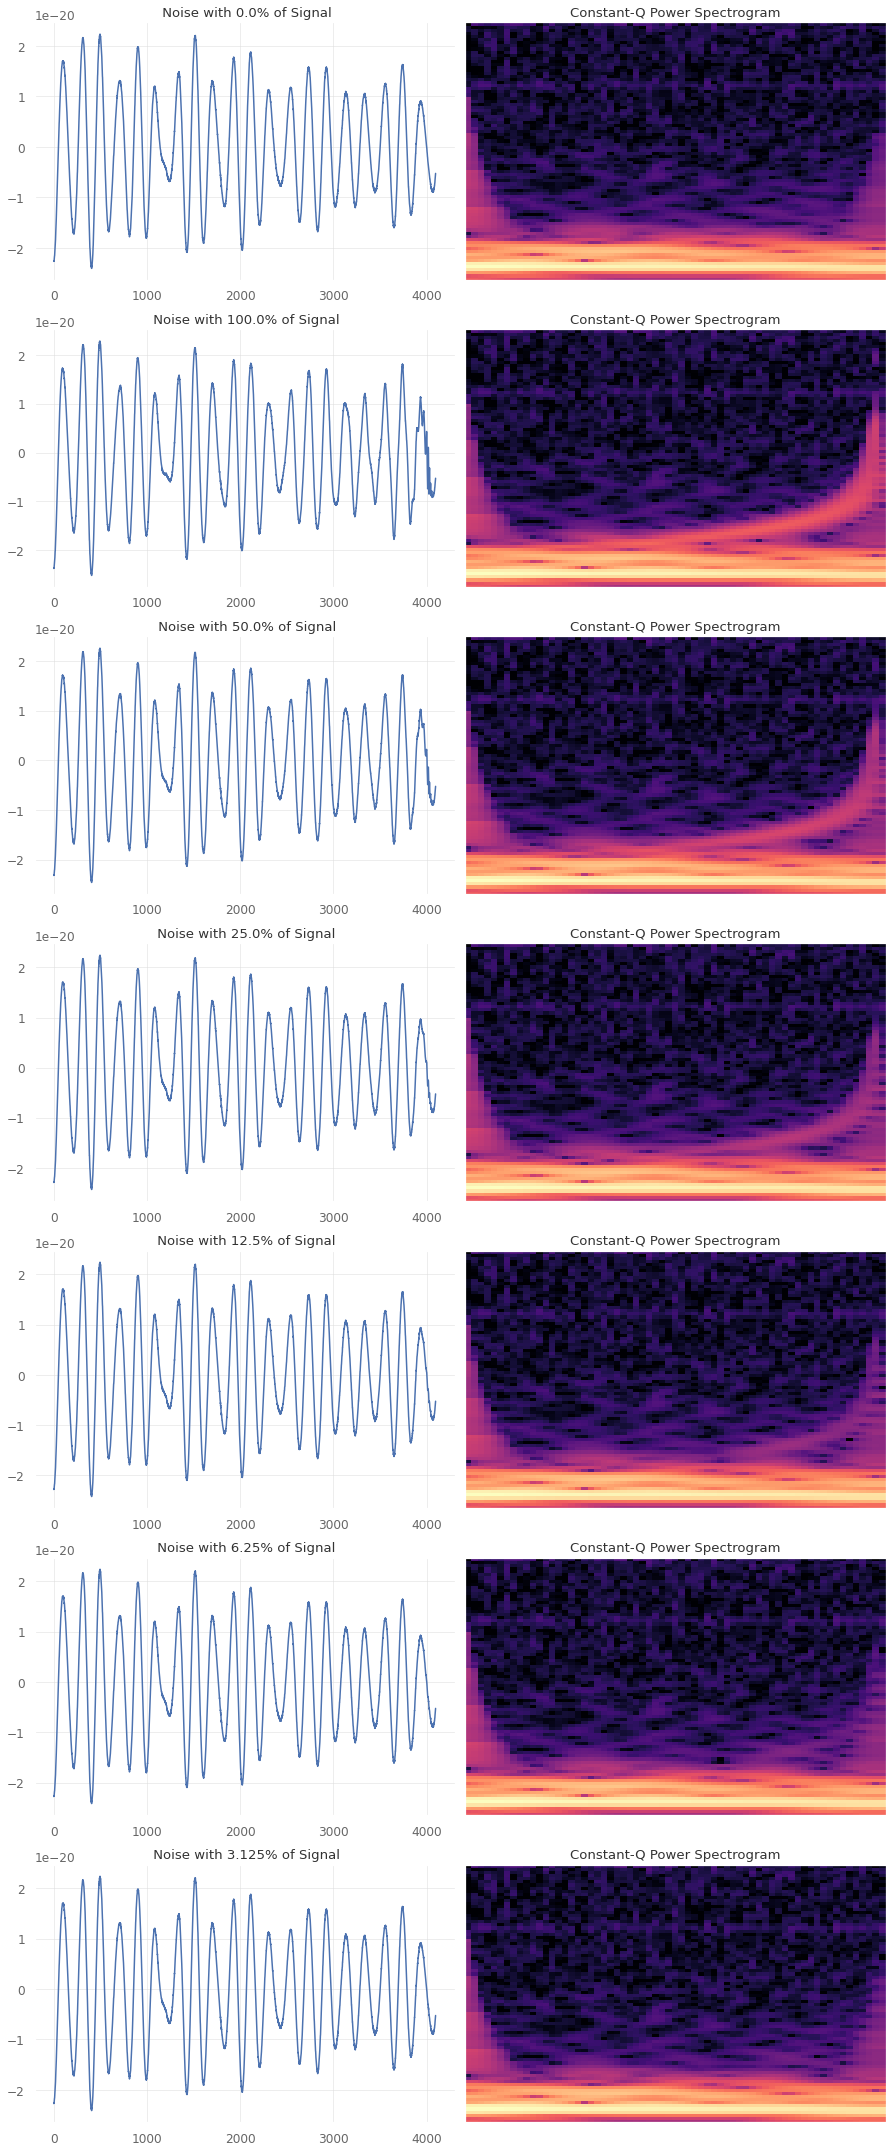

In [ ]:
fig = plt.figure(figsize=(12.5,30))
fig.tight_layout()
d = 100.0
for idx, i in enumerate(gain_intervals):
  signal_and_noise = include_noise(gain=i, signal=d2)
  ax = plt.subplot(len(gain_intervals),2, 1+idx*2)
  plt.plot(signal_and_noise)
  plt.title(f' Noise with {i*100}% of Signal')
  
  
  ax = plt.subplot(len(gain_intervals), 2, 2+idx*2)
  C = np.abs(librosa.cqt(signal_and_noise/np.max(signal_and_noise), sr=SR, hop_length=hop_length, fmin=8, filter_scale=0.8, bins_per_octave=12))
  img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=SR*2, hop_length=hop_length, bins_per_octave=12, ax=ax)
  plt.title('Constant-Q Power Spectrogram')
  plt.tight_layout()



  # z = snr.polynomial_redshift(d)
  # inputarray = noise[:,0]
  # inputarray = snr.redshift_distance_adjustment(signal_and_noise,d,z)

  # freqmax, freqmin = snr.frequency_limits(inputarray)
  # fourieramp = snr.findchirp_fourier(inputarray, d2,d,z)
  # noise_freq_amp = snr.amplitude_interpolation(inputarray,fourieramp,noisearray,freqmax,freqmin)
  # ind_SNR = snr.individual_detector_SNR(noisearray,noise_freq_amp)
  # print(ind_SNR)